# Statistical Rethinking: Chapter 4 Practice Answers

### 4E1

Line 1: $y_i \sim \text{Normal}(\mu,\sigma)$

### 4E2

Two parameters are in the posterior: $\mu$ and $\sigma$.

### 4E3

We can express our posterior joint distribution over $\mu$ and $\sigma$ as:

$$P(\mu,\sigma|\mathbf{y}) = \frac{\prod_i\text{Normal}(y_i|\mu,\sigma)\text{Normal}(\mu|0,10)\text{Exponential}(\sigma|1)}{\int\int\prod_i\text{Normal}(y_i|\mu,\sigma)\text{Normal}(\mu|0,10)\text{Exponential}(\sigma|1)d\mu d\sigma}$$



### 4E4

Line 2: $\mu_i = \alpha + \beta x_i$

### 4E5

Three parameters are in the posterior: $\alpha$, $\beta$, and $\sigma$.

### 4M1



In [16]:
import arviz as az
import matplotlib.pyplot as plt
import scipy.stats as stats

Text(0.5, 0, 'y')

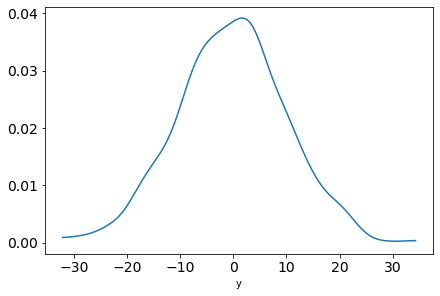

In [18]:
n_samples = 1000
sample_mu = stats.norm.rvs(loc=0, scale=10, size=n_samples)
sample_sigma = stats.expon.rvs(1, size=n_samples)
prior_y = stats.norm.rvs(loc=sample_mu, scale=sample_sigma)
az.plot_kde(prior_y)
plt.xlabel("y")

### 4M2